<a href="https://colab.research.google.com/github/Pojezdal/KNNProject/blob/Denis/source/KNN_compressai_xpojez00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#KNN Projekt

Denis Pojezdál xpojez00\
Ivan Rachler xrachl00\
Sebastián Chupáč xchupa03


In [1]:

!pip install lpips
!pip install piq
!pip install compressai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 523.4 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
running_on_colab = False
try:
    import google.colab
    running_on_colab = True
except:
    running_on_colab = False

Import modules

In [3]:
import time
import piq
import lpips
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
from enum import Enum
import os
import random
import math
import imageio
import compressai
from compressai.optimizers import net_aux_optimizer
from compressai.models import FactorizedPrior
from compressai.models.utils import conv, deconv
from compressai.layers import GDN, MaskedConv2d
from compressai.entropy_models import EntropyBottleneck, GaussianConditional
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


Choose device


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


### Dataset and dataloader

Load the STL10 dataset and split it into training and validation set. Kodak dataset is also loaded so it can be used where required.

In [6]:
if running_on_colab:
    dataset_path = "/content/drive/My Drive/knn_datasets/"
else:
    dataset_path = "../datasets/"

class DataLoader:
    def __init__(self, dataset, ratio = [0.75, 0.2, 0.05], batch_size = 64, name = None):
        self.dataset = dataset
        train_data, val_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset) * ratio) for ratio in ratio])
        self.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) if len(train_data) > 0 else None
        self.val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False) if len(val_data) > 0 else None
        self.test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False) if len(test_data) > 0 else None
        self.batch_size = batch_size
        self.name = name if name is not None else "Not specified"
        print(f"Train size: {len(train_data)}")

stl10_dataset = torchvision.datasets.STL10(root=dataset_path, split='unlabeled', transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()]), download=True)

kodak_dataset = torchvision.datasets.ImageFolder(root=f"{dataset_path}kodak/", transform=transforms.ToTensor())

stl10 = DataLoader(
    stl10_dataset,
    ratio = [0.8, 0.2, 0.0],
    name = "STL",
)

kodak = DataLoader(
    kodak_dataset,
    ratio = [0.0, 1, 0.0],
    name = "Kodak",
)

Files already downloaded and verified
Train size: 80000
Train size: 0


### Psnr and bpp

Method to calculate psnr and bpp from the provided model on validation dataset.
The method expect the input and output images to be in range [0, 1].

In [7]:
normalize_to_0_1 = torchvision.transforms.Normalize((-1,), (2,))
normalize_to_1_1 = torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

def psnr_bpp(model, dataloader):
    model.update()
    compressed_size = 0
    image_size = 0
    total_psnr = 0
    batch_count = 0
    for batch, _ in dataloader.val_loader:
        images = batch.to(device)
        image_size += images.shape[0] * images.shape[2] * images.shape[3]
        output = model.compress(images)
        for strings in output["strings"]:
            for string in strings:
                compressed_size += len(string) * 8

        images_rec = model.decompress(output["strings"], output["shape"])["x_hat"]
        total_psnr += piq.psnr(images, images_rec).item()
        batch_count += 1

    bpp = compressed_size / image_size
    psnr = total_psnr / batch_count
    return psnr, bpp

### Configuration

Configuration of the model and training. Specifying path in load_model will load the stored model so the training can be resumed.
Loss alpha specifies the distortion-rate ratio, increasing it will put more preasure on optimizing the distortion.

In [9]:
if running_on_colab:
    model_path = "/content/drive/My Drive/knn_models/"
else:
    model_path = "../models/"

class TrainConfig:
    def __init__(self, model, epochs, dataloader, loss_metric, loss_alpha, main_optimizer, aux_optimizer, main_scheduler = None, aux_scheduler = None,
                 save_path = None, custom_name = None, start_epoch = 0, best_loss = float('inf'), total_time = 0, load_model = None, loss_transform = None):
        self.model = model
        self.epochs = epochs
        self.dataloader = dataloader
        self.loss_metric = loss_metric
        self.loss_alpha = loss_alpha
        self.main_optimizer = main_optimizer
        self.aux_optimizer = aux_optimizer
        self.main_scheduler = main_scheduler
        self.aux_scheduler = aux_scheduler
        self.save_path = save_path if save_path else model_path
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)
        if not os.path.exists(self.save_path + "/logs"):
            os.makedirs(self.save_path + "/logs")
        self.custom_name = custom_name if custom_name else time.strftime("%Y%m%d_%H%M%S")
        self.start_epoch = start_epoch
        self.best_loss = best_loss
        self.total_time = total_time
        self.loss_transform = loss_transform

        self.load_model = load_model
        if self.load_model:
            self.load_from_checkpoint(self.load_model)

    def load_from_checkpoint(self, path):
        checkpoint = torch.load(path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state'])
        self.main_optimizer.load_state_dict(checkpoint['main_optimizer_state'])
        self.aux_optimizer.load_state_dict(checkpoint['aux_optimizer_state'])
        if self.main_scheduler and checkpoint['main_scheduler_state']:
            self.main_scheduler.load_state_dict(checkpoint['main_scheduler_state'])
        if self.aux_scheduler and checkpoint['aux_scheduler_state']:
            self.aux_scheduler.load_state_dict(checkpoint['aux_scheduler_state'])
        self.best_loss = checkpoint['best_loss']
        self.start_epoch = checkpoint['epoch']
        self.total_time = checkpoint['total_time']

    def save_checkpoint(self, path : str, best_loss, epoch, total_time):
        torch.save({
                'model_state': self.model.state_dict(),
                'main_optimizer_state': self.main_optimizer.state_dict(),
                'aux_optimizer_state': self.aux_optimizer.state_dict(),
                'main_scheduler_state': self.main_scheduler.state_dict() if self.main_scheduler else None,
                'aux_scheduler_state': self.aux_scheduler.state_dict() if self.aux_scheduler else None,
                'best_loss': best_loss,
                'epoch': epoch,
                'total_time': total_time,
                },
            path)

### Model

Modified version of the bmshj_factorized model to enable adjusting of number of layers and entorpy filters. 

In [78]:
class FactorizedPriorReduced(FactorizedPrior):
    def __init__(self, N, M, hidden_layers = 2, entropy_filters = (3, 3, 3, 3), **kwargs):
        super().__init__(N, M, **kwargs)

        self.hidden_layers = hidden_layers

        self.entropy_bottleneck = EntropyBottleneck(M, filters=entropy_filters)

        self.g_a = nn.Sequential(
            conv(3, N),
            GDN(N),
        )
        for i in range(hidden_layers):
            self.g_a.add_module(f'conv{i}', conv(N, N))
            self.g_a.add_module(f'gdn_f{i}', GDN(N))
        self.g_a.add_module('convL', conv(N, M))


        self.g_s = nn.Sequential(
            deconv(M, N),
            GDN(N, inverse=True),
        )
        for i in range(hidden_layers):
            self.g_s.add_module(f'deconv{i}', deconv(N, N))
            self.g_s.add_module(f'gdn_b{i}', GDN(N, inverse=True))
        self.g_s.add_module('deconvL', deconv(N, 3))
        self.g_s.add_module('output', nn.Sigmoid())

    @property
    def downsampling_factor(self) -> int:
        return 2**(self.hidden_layers + 2)


### Configuration setup

Training configuration for the current model.

Beta and gamma parameters are used to set the ration between the different metrics used for distortion calculation.

In [111]:
model_reduced = FactorizedPriorReduced(64, 96).to(device)

opt_conf = {
    "net": {"type": "Adam", "lr": 0.0001},
    "aux": {"type": "Adam", "lr": 0.001},
}
optimizer = net_aux_optimizer(model_reduced, opt_conf)
main_optimizer = optimizer["net"]
aux_optimizer = optimizer["aux"]

metric_lpips = lpips.LPIPS(net="alex").to(device)
metric_mssim = piq.MultiScaleSSIMLoss(kernel_size = 5).to(device)

loss_beta = 2
loss_gamma = 1

train_conf = TrainConfig(
    model = model_reduced,
    epochs = 2,
    dataloader = stl10,
    loss_metric = lambda x_rec, x: metric_lpips(normalize_to_1_1(x_rec), normalize_to_1_1(x)).mean() * loss_beta + metric_mssim(x_rec, x) * loss_gamma,
    loss_alpha = 10,
    main_optimizer = main_optimizer,
    aux_optimizer = aux_optimizer,
    main_scheduler = optim.lr_scheduler.MultiplicativeLR(main_optimizer, lambda epoch: 0.98),
    aux_scheduler = optim.lr_scheduler.MultiplicativeLR(aux_optimizer, lambda epoch: 0.98),
    custom_name = "reduced_94_94_10_lpips2_mssim_sigmoid_test",
    load_model = f"{model_path}reduced_64_96_4_100_lpips_ssim-3_sigm_best.pth"
)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


### Logging

Methods for logging the training progress.

In [20]:
def log_header(file, conf):
    file.write(f"========= Model =========\n")
    file.write(f"Loaded from checkpoint: {conf.load_model if conf.load_model else 'No'}\n")
    file.write(str(conf.model))
    file.write(f"========= Data Loader =========\n")
    file.write(f"Name: {conf.dataloader.name}\n")
    file.write(f"Batch size: {conf.dataloader.batch_size}\n")
    file.write(f"Training samples: {len(conf.dataloader.train_loader.dataset) if conf.dataloader.train_loader else '0'}\n")
    file.write(f"Validation samples: {len(conf.dataloader.val_loader.dataset) if conf.dataloader.val_loader else '0'}\n")
    file.write(f"Test samples: {len(conf.dataloader.test_loader.dataset) if conf.dataloader.test_loader else '0'}\n")
    file.write(f"========= Loss Function =========\n")
    file.write(f"Metric: {conf.loss_metric._get_name() if hasattr(conf.loss_metric, '_get_name') else conf.loss_metric.__class__.__name__}\n")
    file.write(f"Alpha: {conf.loss_alpha}\n")
    file.write(f"Aux target: {conf.model.entropy_bottleneck.target.tolist()}\n")
    file.write(f"========= Optimizers =========\n")
    file.write(f"Main optimizer: {conf.main_optimizer.__class__.__name__}\n")
    file.write(f"Main learning rate: {conf.main_optimizer.param_groups[0]['lr']}\n")
    file.write(f"Aux optimizer: {conf.aux_optimizer.__class__.__name__}\n")
    file.write(f"Aux learning rate: {conf.aux_optimizer.param_groups[0]['lr']}\n")
    file.write(f"========= Schedulers =========\n")
    file.write(f"Main scheduler: {conf.main_scheduler.__class__.__name__ if conf.main_scheduler else 'None'}\n")
    file.write(f"Main parameters: {conf.main_scheduler.state_dict() if conf.main_scheduler else 'None'}\n")
    file.write(f"Aux scheduler: {conf.main_scheduler.__class__.__name__ if conf.main_scheduler else 'None'}\n")
    file.write(f"Aux parameters: {conf.main_scheduler.state_dict() if conf.main_scheduler else 'None'}\n")
    file.write(f"========= Training =========\n")

def log_epoch(file, index, total, main_loss, dist_loss, bpp_loss, aux_loss, main_lr, aux_lr, time):
    file.write(f"Epoch [{index + 1}/{total}]: main_loss {main_loss:.6f}, distortion {dist_loss:.6f}, bpp {bpp_loss:.6f}, aux_loss {aux_loss:.6f}, main lr {main_lr:.4g}, aux lr {aux_lr:.4g} time {time:.2f}\n")
    file.flush()

def log_finalize(file, best_loss, psnr, bpp, time):
    file.write(f"========= Summary =========\n")
    file.write(f"Best loss: {best_loss:.6f}\n")
    file.write(f"Final psnr: {psnr:.2f}\n")
    file.write(f"Final bpp: {bpp:.4f}\n")
    file.write(f"Total time: {time:.2f}\n")

### Loss function

Main loss function that uses the reconstructed images and distortion metric to calculate the distortion part
and likelihoods of the latent representation to estimate the avarage bpp used as the bpp part of the loss.

Alpha is used to scale the distortion to allow adjusting the distortion-rate ratio.

In [16]:
def loss_function(x, x_recon, likelihoods, metric, alpha, transform):
    pixel_count = x.shape[0] * x.shape[2] * x.shape[3]
    if transform:
        distortion = metric(transform(x_recon), transform(x)).mean() * alpha
    else:
        distortion = metric(x_recon, x).mean() * alpha
    bpp = sum((-torch.log(likelihood).sum() / (pixel_count * math.log(2))) for likelihood in likelihoods.values())
    return distortion + bpp, distortion, bpp

### Training loop

Both the main loss consisting of distortion and bpp part and auxilary loss are calculated after each batch.

In [36]:
def train(conf : TrainConfig):
    log_file = open(f"{conf.save_path}/logs/{conf.custom_name}.log", "w")
    log_header(log_file, conf)

    model, dataloader, loss_metric, loss_alpha, loss_transform = conf.model, conf.dataloader, conf.loss_metric, conf.loss_alpha, conf.loss_transform
    main_optimizer, aux_optimizer, main_scheduler, aux_scheduler = conf.main_optimizer, conf.aux_optimizer, conf.main_scheduler, conf.aux_scheduler
    start_epoch, end_epoch = conf.start_epoch, conf.start_epoch + conf.epochs
    best_loss, total_time = conf.best_loss, conf.total_time
    for epoch in range(start_epoch, end_epoch):
        start_time = time.time()
        model.train()
        for i, (x, _) in enumerate(dataloader.train_loader):
            print(f"\rProcessing batch {i + 1}/{len(dataloader.train_loader)}", end="")
            x = x.to(device)

            output = model(x)
            x_recon = output["x_hat"]
            likelihoods = output["likelihoods"]

            main_loss, _, _ = loss_function(x, x_recon, likelihoods, loss_metric, loss_alpha, loss_transform)

            main_optimizer.zero_grad()
            main_loss.backward()
            main_optimizer.step()

            aux_loss = model.aux_loss()

            aux_optimizer.zero_grad()
            aux_loss.backward()
            aux_optimizer.step()

        model.eval()
        with torch.no_grad():
            for x, _ in dataloader.val_loader:
                x = x.to(device)

                output = model(x)
                x_recon = output["x_hat"]
                likelihoods = output["likelihoods"]

                main_loss, dist_loss, bpp_loss = loss_function(x, x_recon, likelihoods, loss_metric, loss_alpha, loss_transform)
                aux_loss = model.aux_loss()

            end_time = time.time()
            epoch_duration = end_time - start_time
            total_time += epoch_duration
            print(f"\rEpoch [{epoch + 1}/{end_epoch}]: main_loss {main_loss:.6f}, distortion {dist_loss:.6f}, bpp {bpp_loss:.6f}, aux_loss {aux_loss:.6f}, time {epoch_duration:.2f}")
            log_epoch(log_file, epoch, end_epoch, main_loss, dist_loss, bpp_loss, aux_loss, main_optimizer.param_groups[0]['lr'], aux_optimizer.param_groups[0]['lr'], epoch_duration)

        if main_loss < best_loss:
            best_loss = main_loss
            conf.save_checkpoint(f"{conf.save_path}/{conf.custom_name}_best.pth", best_loss, epoch, total_time)

        if main_scheduler:
            main_scheduler.step()

        if aux_scheduler:
            aux_scheduler.step()

    psnr, bpp = psnr_bpp(model, dataloader)

    log_finalize(log_file, best_loss, psnr, bpp, total_time)

    conf.save_checkpoint(f"{conf.save_path}/{conf.custom_name}_last.pth", best_loss, end_epoch, total_time)


### Start training

Begin training based on the configuration.

In [39]:
train(train_conf)

Epoch [3/4]: main_loss 3.453227, distortion 2.529118, bpp 0.924109, aux_loss 1890.826416, time 208.39
Epoch [4/4]: main_loss 3.218602, distortion 2.318929, bpp 0.899673, aux_loss 1600.196411, time 207.94


### Inference

Perform inference on the selected batch of the dataloader.

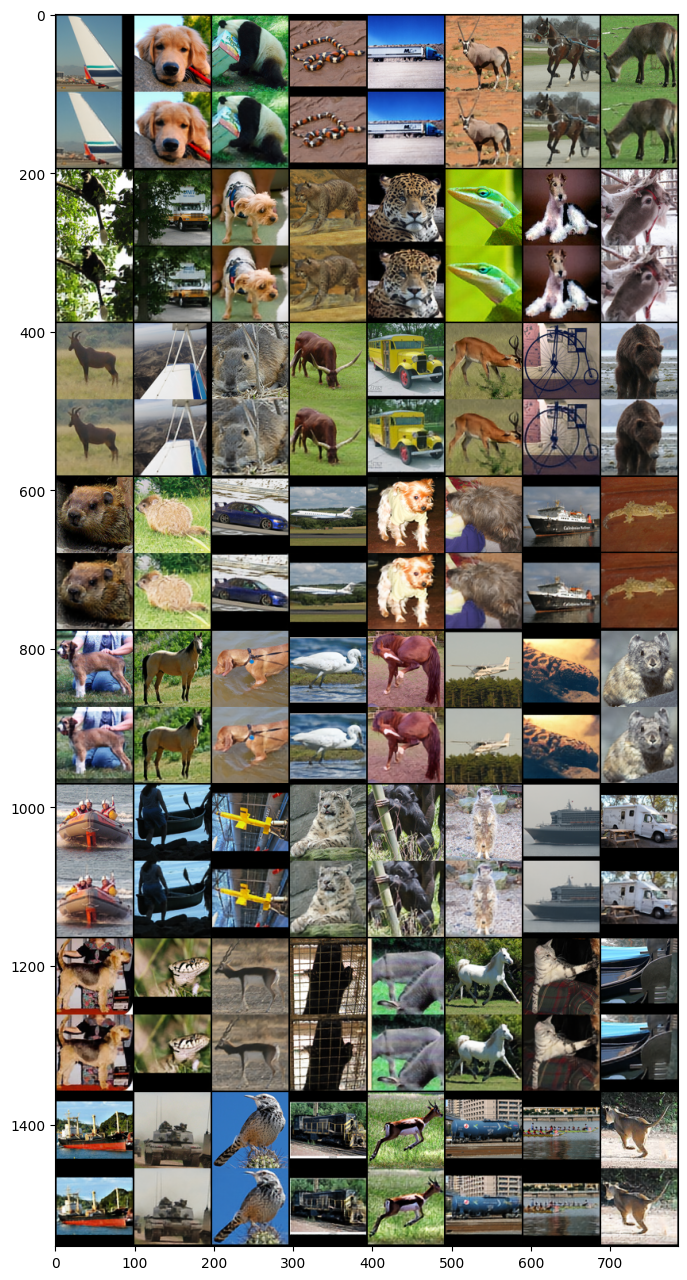

In [115]:
if running_on_colab:
    image_path = "/content/drive/My Drive/knn_images/"
else:
    image_path = "../images/"

def inference(model, dataloader, name, index = 0):
    for i, (batch, _) in enumerate(dataloader):
        if i != index:
            continue
        images = batch.to(device)
        if len(images.shape) < 4:
            images = images.unsqueeze(0)
        output = train_conf.model(images)["x_hat"]
        images = torch.cat([images, output], dim=2)

        npimage = torchvision.utils.make_grid(images.detach()).cpu().numpy()
        npimage = npimage.transpose(1, 2, 0)

        imageio.imwrite(f"{image_path}{name}", (npimage * 255).astype(np.uint8))

        plt.figure(figsize=(20, 16))
        plt.imshow(npimage)
        plt.show()
        break

inference(train_conf.model, stl10.val_loader, "test.png", 12)

### Plot the psnr over bpp graph

PSNR: 22.77, BPP: 0.9283


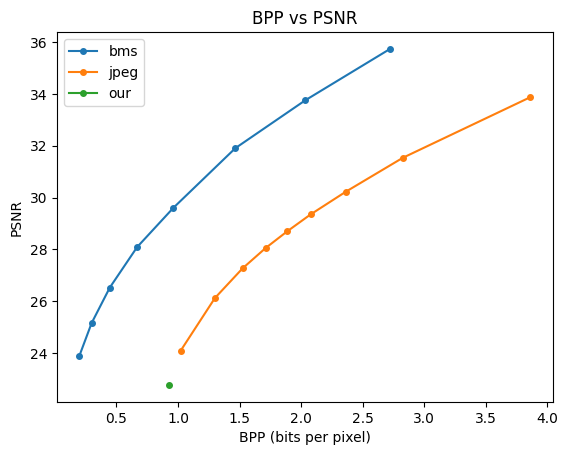

In [51]:
baseline_metrics = {    ## 500 images from the validation set of stl10 dataset (unlabeled split)
"bms": {
    "bpp": [0.19988194444444443, 0.2988402777777776, 0.44673611111111056, 0.6683263888888891, 0.9627986111111108, 1.4655763888888897, 2.0330416666666653, 2.7216875000000007],
    "psnr": [23.897150814056396, 25.15504557800293, 26.526659744262695, 28.087163276672364, 29.60244454574585, 31.903252914428712, 33.75015351486206, 35.73424911880493]},
"jpeg": {
    "bpp": [1.0225347222222223, 1.300105902777778, 1.5240902777777778, 1.7105746527777783, 1.886397569444444, 2.076463541666668, 2.363946180555556, 2.8256059027777805, 3.8610625000000014],
    "psnr": [24.0933437461853, 26.12165872192383, 27.2635897064209, 28.046062282562257, 28.69297319030762, 29.346161067962647, 30.227422931671143, 31.532780990600585, 33.8721844291687]}
}

msssim_baseline_metrics = {
"bms": {
    "bpp": [0.12609027777777776, 0.18234027777777767, 0.2639791666666668, 0.3681875000000006, 0.5104999999999996, 0.6730347222222219, 0.8957916666666671, 1.20357638888889],
    "psnr": [21.257686344146727, 22.253188648223876, 23.349189826965333, 24.287573760986326, 25.30987477874756, 26.3740486907959, 27.460073432922364, 28.656918861389162]},
"jpeg": {
    "bpp": [1.0227777777777778, 1.3023402777777784, 1.5262986111111116, 1.7127708333333331, 1.888520833333333, 2.0786458333333315, 2.365657986111111, 2.8297343749999992, 3.864128472222219],
    "psnr": [24.10634324645996, 26.16938330078125, 27.316714889526367, 28.109992641448976, 28.760773368835448, 29.414331382751463, 30.30017582321167, 31.62249006652832, 34.004099689483645]}
}

psnr, bpp = psnr_bpp(train_conf.model, train_conf.dataloader)
print(f"PSNR: {psnr:.2f}, BPP: {bpp:.4f}")
baseline_metrics["our"] = {"bpp": [bpp], "psnr": [psnr]}

def plot_psnr_bpp(model_metrics):
    plt.xlabel('BPP (bits per pixel)')
    plt.ylabel('PSNR')
    plt.title('BPP vs PSNR')
    for model, metrics in model_metrics.items():
        plt.plot(metrics["bpp"], metrics["psnr"], 'o-', markersize=4, label=model)
    plt.legend()
    plt.show()

plot_psnr_bpp(baseline_metrics)